# Energy Dependent Gaussian in 0.18.2 

## Context: 
With 3D FoV modelling have reports of detection of two overlapping gaussians 
-  hard spectrum, small size 
-  soft spectrum, large size

## Question:
Can this point to an underlying energy energy dependent morphology?

## To investigate
- Create an energy dependent gaussian
- $\sigma \sim \sigma(Eˆ{-\alpha})$
- Simulate for an advection dominated case, $\alpha = 1$
- Fit with the same model 
- Fit with two gaussians
- Use HESS DL3 DR1

## Inference

Looking at the residuals, it seems that a sum of two gaussains successfully reproduces the simulated dataset. This can indeed lead people to draw misleading conclusions.

## Suggestion

Use the AIC to compare likelihoods for non-nested models to distinguish in such cases

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.coordinates.angle_utilities import angular_separation, position_angle
from regions import CircleSkyRegion, RectangleSkyRegion
from gammapy.data import DataStore, Observation
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import (
    MapDatasetMaker,  
    SafeMaskMaker, 
    FoVBackgroundMaker
)
from gammapy.datasets import MapDataset
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    SpatialModel,
    FoVBackgroundModel,
    Models,
    GaussianSpatialModel
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.modeling import Parameter, Parameters, Fit
from astropy.coordinates.angle_utilities import angular_separation
import scipy.stats
from gammapy.estimators import ExcessMapEstimator

In [2]:
def plot_hist(sig_map, ax, label="", color="blue"):
    sig = sig_map.data.ravel()
    ax.hist(
        sig,
        density=True,
        alpha=0.5,
        color=color,
        bins=100,
    )
    ax.set_title(label)
    mu, std = scipy.stats.norm.fit(sig)
    x = np.linspace(-8, 8, 50)
    p = scipy.stats.norm.pdf(x, mu, std)
    ax.plot(x, p, lw=2, color=color)
    ax.legend()
    ax.set_xlabel("Significance")
    ax.set_xlim(-5,5)
    ax.set_yscale("log")
    ax.set_ylim(1e-3, 1)
    
    ax.text(2,0.5, f"mu = {mu:.2f}")
    ax.text(2,0.3, f"std = {std:.2f}")

    print(f" {label}: mu = {mu:.2f}, std = {std:.2f}")
    
    p = scipy.stats.norm.pdf(x, 0, 1)
    plt.plot(x, p, lw=2, color="black")

In [3]:
class PWNGaussianModel(SpatialModel):
    """My custom Energy Dependent Gaussian model.

    Parameters
    ----------
    lon_0, lat_0 : `~astropy.coordinates.Angle`
        Center position
    sigma_1TeV : `~astropy.coordinates.Angle`
        Width of the Gaussian at 1 TeV
    sigma_10TeV : `~astropy.coordinates.Angle`
        Width of the Gaussian at 10 TeV

    """

    tag = "PWNGaussianModel"
    lon_0 = Parameter("lon_0", "0 deg")
    lat_0 = Parameter("lat_0", "0 deg", min=-90, max=90)
    alpha = Parameter("alpha", 1.0) #energy dependence of sigma
    ref = Parameter("ref", "1 TeV", frozen=True)
    sigma_ref = Parameter("sigma_ref", "1.0 deg", min=0) #sigma at reference value
    
    is_energy_dependent = True
    

    @staticmethod
    def get_sigma(energy, alpha, ref, sigma_ref):
        """Get the sigma for a particular energy"""
        sigma = sigma_ref * np.power(energy/ref, -alpha)
        return sigma

    def evaluate(
        self, lon, lat, energy, lon_0, lat_0, alpha, ref, sigma_ref,
    ):
        """Evaluate custom Gaussian model"""

        sigma = self.get_sigma(energy, alpha.value, ref, sigma_ref)
        sep = angular_separation(lon, lat, lon_0, lat_0)

        exponent = -0.5 * (sep / sigma) ** 2
        norm = 1 / (2 * np.pi * sigma ** 2)
        return norm * np.exp(exponent)

    @property
    def evaluation_radius(self):
        """Evaluation radius (`~astropy.coordinates.Angle`)."""
        return 5.0 * self.sigma_ref.quantity

In [4]:
spatial_model = PWNGaussianModel()
spectral_model = PowerLawSpectralModel()
sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model
)


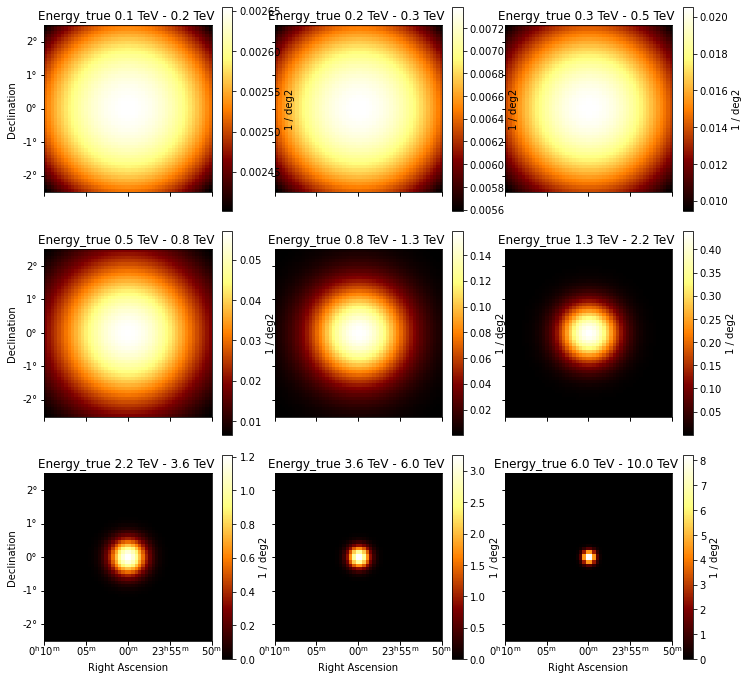

In [83]:
energy_axis = MapAxis.from_energy_bounds(
    energy_min=0.1 * u.TeV, energy_max=10.0 * u.TeV, nbin=9, name="energy_true"
)
geom_plot = WcsGeom.create(
    skydir=(0, 0), width=5.0 * u.deg, binsz=0.1, axes=[energy_axis]
)
spatial_model.plot_grid(geom=geom_plot, add_cbar=True);

In [6]:
spatial_model.get_sigma([0.5,1.0,10.0]*u.TeV,
                       alpha=1.0,
                       ref=1.0*u.TeV,
                       sigma_ref=1.0*u.deg)

<Quantity [2. , 1. , 0.1] deg>

## Simulations

In [7]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs = data_store.obs(20137)
irfs = {'aeff': obs.aeff,
        'edisp': obs.edisp,
        'psf': obs.psf,
        'bkg': obs.bkg}

In [8]:
obs.pointing_radec.galactic

<SkyCoord (Galactic): (l, b) in deg
    (320.04726045, -1.73977654)>

In [9]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 20.0 * u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

In [10]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-0.1, 1.3, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.01,
    width=(4, 4),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy", interp="log"
)
energy_reco.edges

<Quantity [ 0.79432823,  1.13646367,  1.62596469,  2.32630507,  3.32829814,
            4.76187266,  6.81292069,  9.74740226, 13.94583249, 19.95262315] TeV>

In [11]:
simu_spatial = PWNGaussianModel(frame='galactic')
simu_spectal = PowerLawSpectralModel()
model_simu = SkyModel(spatial_model=simu_spatial,
                     spectral_model = simu_spectal, name='model_simu')
model_simu.parameters['lon_0'].value = 0.0
model_simu.parameters['lat_0'].value = 0.0
model_simu.parameters['amplitude'].value = 1.0e-11
model_simu.parameters['index'].value = 2.0
model_simu.parameters['alpha'].value = 1.0

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")
models = Models([model_simu, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model_simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PWNGaussianModel
  Temporal model type       : 
  Parameters:
    index                   :   2.000              
    amplitude               :   1.00e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0                   :   0.000  deg         
    lat_0                   :   0.000  deg         
    alpha                   :   1.000              
    ref          (frozen)   :   1.000  TeV         
    sigma_ref               :   1.000  deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)

In [12]:
# Create an in-memory observation
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
# Make the MapDataset
empty = MapDataset.create(geom, name="dataset-simu")
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)
dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)
dataset.models = models
dataset.fake()
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 97481 
  Total background counts         : 94879.27
  Total excess counts             : 2601.73

  Predicted counts                : 97494.10
  Predicted background counts     : 94879.27
  Predicted excess counts         : 2614.83

  Exposure min                    : 9.25e+08 m2 s
  Exposure max                    : 3.70e+10 m2 s

  Number of total bins            : 1440000 
  Number of fit bins              : 1440000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 635982.65

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : model_simu
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PWNGaussianModel
    Temporal model type       : 
    Parameters:
  

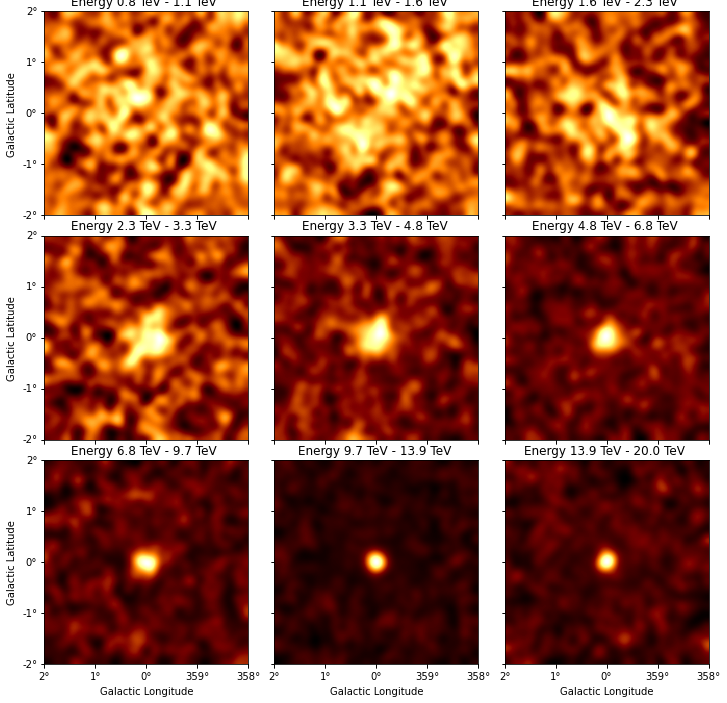

In [13]:
dataset.excess.smooth(0.1*u.deg).plot_grid();

In [14]:
estimator_ene = ExcessMapEstimator(correlation_radius=0.2*u.deg, 
                               energy_edges=energy_reco.edges,
                               selection_optional=None)

## Fit

### With energy dependent model

In [15]:
dataset1 = dataset.copy(name='dataset1')

In [16]:
models = Models(dataset1.models['dataset1-bkg'])
dataset1.models = models

In [17]:
%%time
fit0 = Fit([dataset1]) #background only
result0 = fit0.run(optimize_opts={"print_level": 1})
L0 = dataset1.stat_sum()
AIC_0 = 2*len(result0.parameters.free_parameters.names) + result0.total_stat
print(result0.parameters.to_table())

------------------------------------------------------------------
| FCN = 6.373e+05               |      Ncalls=18 (18 total)      |
| EDM = 3.35e-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
   name     value    unit min max frozen   error  
--------- ---------- ---- --- --- ------ ---------
     norm 1.0274e+00      nan nan  False 3.291e-03
     tilt 0.0000e+00      nan nan   True 0.

In [18]:
fit_spatial = PWNGaussianModel(frame='galactic')
fit_spectal = PowerLawSpectralModel()
model_fit = SkyModel(spatial_model=fit_spatial,
                     spectral_model = fit_spectal, name='model_simu')
model_fit.parameters['lon_0'].value = 0.01
model_fit.parameters['lat_0'].value = 0.01
model_fit.parameters['amplitude'].value = 1.0e-11
model_fit.parameters['amplitude'].min = 0.0
model_fit.parameters['index'].value = 2.3
model_fit.parameters['index'].min = 0.0
model_fit.parameters['alpha'].value = 1.0
model_fit.parameters['alpha'].max = 2.0

models.append(model_fit)
dataset1.models = models
print(dataset1)

MapDataset
----------

  Name                            : dataset1 

  Total counts                    : 97481 
  Total background counts         : 94879.27
  Total excess counts             : 2601.73

  Predicted counts                : 99505.27
  Predicted background counts     : 97479.19
  Predicted excess counts         : 2026.07

  Exposure min                    : 9.25e+08 m2 s
  Exposure max                    : 3.70e+10 m2 s

  Number of total bins            : 1440000 
  Number of fit bins              : 1440000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 636131.13

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: FoVBackgroundModel
  
    Name                      : dataset1-bkg
    Datasets names            : ['dataset1']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.027              
      tilt

In [19]:
%%time
fit1 = Fit([dataset1])
result1 = fit1.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 6.36e+05                |     Ncalls=577 (577 total)     |
| EDM = 8.93e-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 1min 1s, sys: 3.91 s, total: 1min 5s
Wall time: 1min 6s


In [20]:
L1 = result1.total_stat

In [21]:
print(L0-L1)
AIC_1 = 2*len(result1.parameters.free_parameters.names) + L1

1326.4878443906782


In [22]:
print(dataset1.models.parameters.to_table())

   name      value         unit         min        max    frozen   error  
--------- ----------- -------------- ---------- --------- ------ ---------
     norm  1.0037e+00                       nan       nan  False 3.759e-03
     tilt  0.0000e+00                       nan       nan   True 0.000e+00
reference  1.0000e+00            TeV        nan       nan   True 0.000e+00
    index  1.9663e+00                 0.000e+00       nan  False 8.560e-02
amplitude  8.3042e-12 cm-2 s-1 TeV-1  0.000e+00       nan  False 1.449e-12
reference  1.0000e+00            TeV        nan       nan   True 0.000e+00
    lon_0 -2.5986e-03            deg        nan       nan  False 6.354e-03
    lat_0  4.4289e-03            deg -9.000e+01 9.000e+01  False 6.432e-03
    alpha  1.0598e+00                       nan 2.000e+00  False 7.192e-02
      ref  1.0000e+00            TeV        nan       nan   True 0.000e+00
sigma_ref  1.0003e+00            deg  0.000e+00       nan  False 1.363e-01


/Users/asinha/Gammapy-dev/gammapy/gammapy/maps/wcsnd.py:400: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.imshow(data, **kwargs)


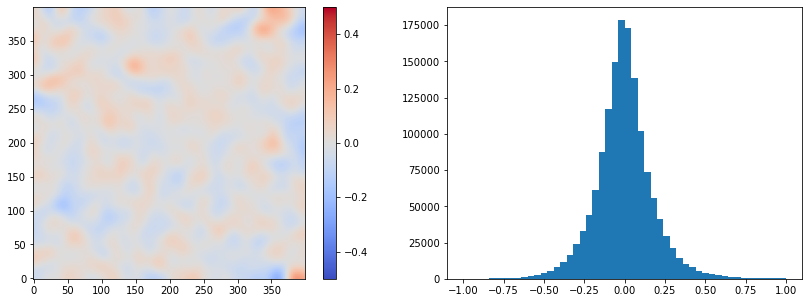

In [23]:
plt.figure(figsize=(14,5))

ax1 = plt.subplot(121)
dataset1.plot_residuals_spatial(method="diff/model", 
                                vmin=-0.5, vmax=0.5,
                               ax = ax1)

ax2 = plt.subplot(122)
ax2.hist(dataset1.residuals(method='diff/model', width=0.1*u.deg).data.ravel(), 
         bins=50, range=[-1,1]);


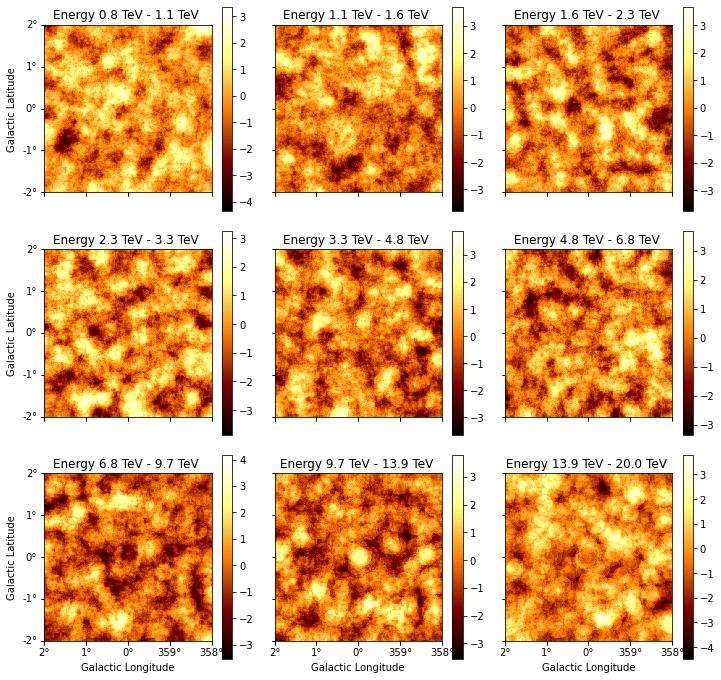

In [24]:
residual1 = estimator_ene.run(dataset1)
residual1['sqrt_ts'].plot_grid(add_cbar=True);

## Now, as a sum of two Gaussians

In [25]:
dataset2 = dataset.copy(name='dataset2')

In [26]:
models2 = Models(dataset2.models['dataset2-bkg'])
dataset2.models = models2

In [27]:
spatial_model2a = GaussianSpatialModel(
    lon_0="0.0 deg", lat_0="0.0 deg", sigma="0.5 deg", frame="galactic"
)
spectral_model2a = PowerLawSpectralModel()
model_fit2a = SkyModel(
    spatial_model=spatial_model2a,
    spectral_model=spectral_model2a,
    name="model-fit2a",
)
model_fit2a.parameters['lon_0'].value = 0.1
model_fit2a.parameters['lat_0'].value = 0.1
model_fit2a.parameters['amplitude'].value = 1.0e-11
model_fit2a.parameters['amplitude'].min = 0.0
model_fit2a.parameters['index'].value = 2.3
model_fit2a.parameters['index'].min = 0.0
model_fit2a.parameters['sigma'].value = 1.0

models2.append(model_fit2a)
dataset2.models = models2
print(dataset2)

MapDataset
----------

  Name                            : dataset2 

  Total counts                    : 97481 
  Total background counts         : 94879.27
  Total excess counts             : 2601.73

  Predicted counts                : 96512.52
  Predicted background counts     : 94879.27
  Predicted excess counts         : 1633.25

  Exposure min                    : 9.25e+08 m2 s
  Exposure max                    : 3.70e+10 m2 s

  Number of total bins            : 1440000 
  Number of fit bins              : 1440000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 637156.80

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: FoVBackgroundModel
  
    Name                      : dataset2-bkg
    Datasets names            : ['dataset2']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt

In [28]:
%%time
fit3 = Fit([dataset2])
result3 = fit3.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 6.362e+05               |     Ncalls=361 (361 total)     |
| EDM = 5.9e-05 (Goal: 0.0002)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 19.3 s, sys: 2.55 s, total: 21.8 s
Wall time: 22 s


In [29]:
L3 = result3.total_stat

In [30]:
print(L0-L3)
AIC_3 = 2*len(result3.parameters.free_parameters.names) + L3

1144.344629033003


/Users/asinha/Gammapy-dev/gammapy/gammapy/maps/wcsnd.py:400: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.imshow(data, **kwargs)


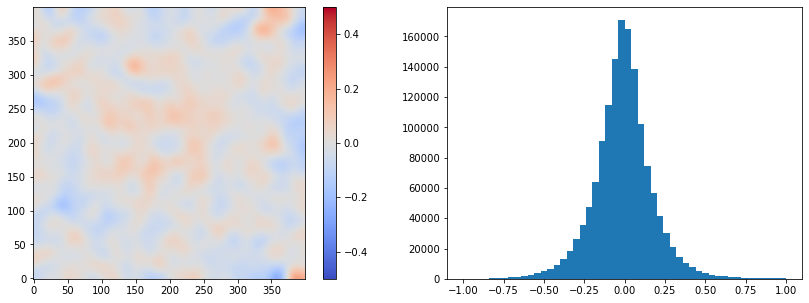

In [31]:
plt.figure(figsize=(14,5))

ax1 = plt.subplot(121)
dataset2.plot_residuals_spatial(method="diff/model", 
                                vmin=-0.5, vmax=0.5,
                               ax = ax1)

ax2 = plt.subplot(122)
ax2.hist(dataset2.residuals(method='diff/model', width=0.1*u.deg).data.ravel(), 
         bins=50, range=[-1,1]);



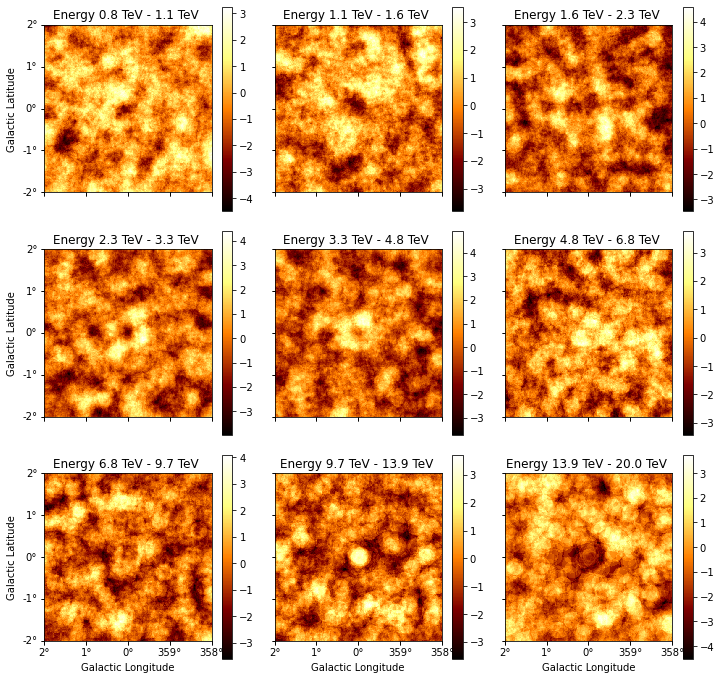

In [32]:
residual3 = estimator_ene.run(dataset2)
residual3['sqrt_ts'].plot_grid(add_cbar=True);

In [33]:
result3.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
norm,1.0184e+00,,nan,nan,False,3.321e-03
tilt,0.0000e+00,,nan,nan,True,0.000e+00
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
index,1.0054e+00,,0.000e+00,nan,False,7.198e-02
amplitude,8.8595e-13,cm-2 s-1 TeV-1,0.000e+00,nan,False,1.428e-13
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
lon_0,-6.3206e-03,deg,nan,nan,False,7.396e-03
lat_0,2.9911e-03,deg,-9.000e+01,9.000e+01,False,7.663e-03
sigma,1.0467e-01,deg,0.000e+00,nan,False,6.104e-03


Add second gaussian

In [34]:
spatial_model2b = GaussianSpatialModel(
    lon_0="0.0 deg", lat_0="0.0 deg", sigma="0.5 deg", frame="galactic"
)
spectral_model2b = PowerLawSpectralModel()
model_fit2b = SkyModel(
    spatial_model=spatial_model2b,
    spectral_model=spectral_model2b,
    name="model-fit2b",
)
model_fit2b.parameters['lon_0'].value = 0.1
model_fit2b.parameters['lat_0'].value = 0.1
model_fit2b.parameters['amplitude'].value = 1.0e-12
model_fit2b.parameters['amplitude'].min = 0.0
model_fit2b.parameters['index'].value = 2.3
model_fit2b.parameters['index'].min = 0.0
model_fit2b.parameters['sigma'].value = 1.0

models2.append(model_fit2b)
dataset2.models = models2
print(dataset2)

MapDataset
----------

  Name                            : dataset2 

  Total counts                    : 97481 
  Total background counts         : 94879.27
  Total excess counts             : 2601.73

  Predicted counts                : 97645.04
  Predicted background counts     : 96623.94
  Predicted excess counts         : 1021.10

  Exposure min                    : 9.25e+08 m2 s
  Exposure max                    : 3.70e+10 m2 s

  Number of total bins            : 1440000 
  Number of fit bins              : 1440000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 636145.16

  Number of models                : 3 
  Number of parameters            : 19
  Number of free parameters       : 11

  Component 0: FoVBackgroundModel
  
    Name                      : dataset2-bkg
    Datasets names            : ['dataset2']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.018              
      til

In [35]:
%%time
fit4 = Fit([dataset2])
result4 = fit4.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 6.361e+05               |     Ncalls=876 (876 total)     |
| EDM = 0.000744 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 1min 21s, sys: 7.89 s, total: 1min 29s
Wall time: 1min 29s


In [36]:
L4 = result4.total_stat
AIC_4 = 2*len(result4.parameters.free_parameters.names) + L4

In [37]:
print(L3-L4)

65.77505633397959


In [38]:
result4.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
norm,9.9587e-01,,nan,nan,False,6.162e-03
tilt,0.0000e+00,,nan,nan,True,0.000e+00
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
index,8.2993e-01,,0.000e+00,nan,False,8.736e-02
amplitude,5.3248e-13,cm-2 s-1 TeV-1,0.000e+00,nan,False,1.111e-13
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
lon_0,-5.0609e-03,deg,nan,nan,False,7.108e-03
lat_0,3.6381e-03,deg,-9.000e+01,9.000e+01,False,7.409e-03
sigma,9.2435e-02,deg,0.000e+00,nan,False,5.985e-03


/Users/asinha/Gammapy-dev/gammapy/gammapy/maps/wcsnd.py:400: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.imshow(data, **kwargs)


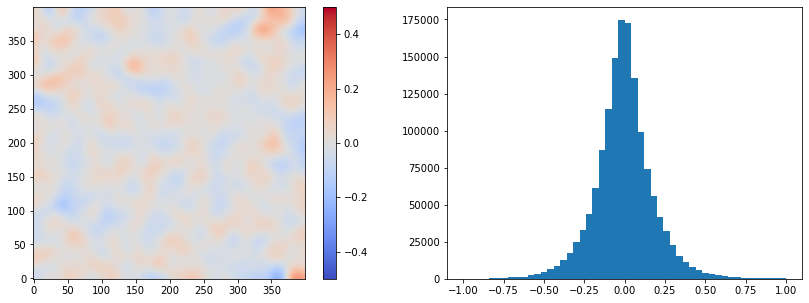

In [39]:
plt.figure(figsize=(14,5))

ax1 = plt.subplot(121)
dataset2.plot_residuals_spatial(method="diff/model", 
                                vmin=-0.5, vmax=0.5,
                               ax = ax1)

ax2 = plt.subplot(122)
ax2.hist(dataset2.residuals(method='diff/model', width=0.1*u.deg).data.ravel(), 
         bins=50, range=[-1,1]);




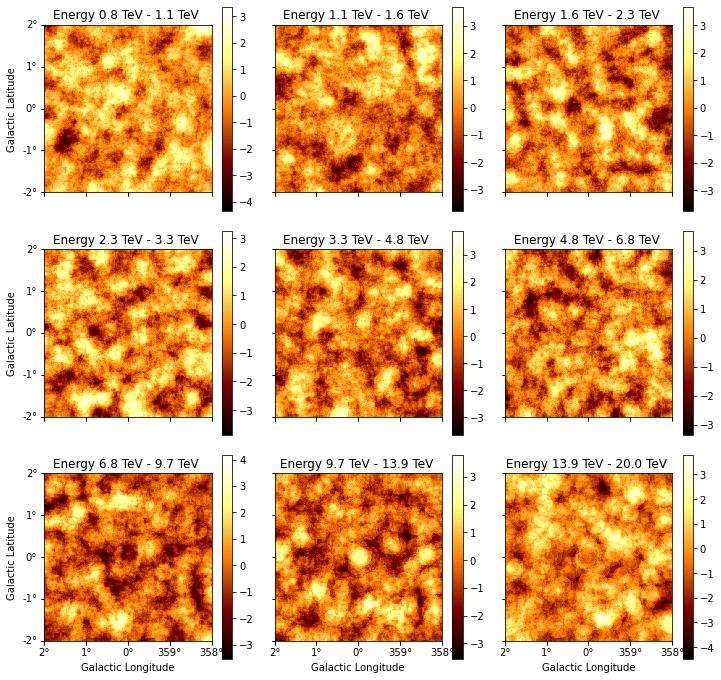

In [40]:
residual4 = estimator_ene.run(dataset1)
residual4['sqrt_ts'].plot_grid(add_cbar=True);

## Differention using visual inspection

Text(0.5, 1.0, 'residual distribution')

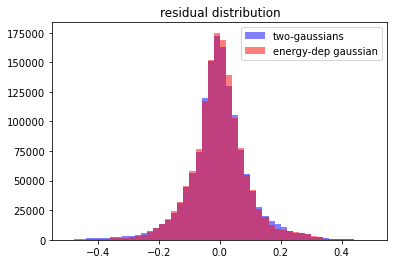

In [41]:
plt.hist(dataset2.residuals(method='diff/model', width=0.2*u.deg).data.ravel(), 
         bins=50, range=[-0.5,0.5], alpha=0.5, label='two-gaussians', color='blue');
plt.hist(dataset1.residuals(method='diff/model', width=0.2*u.deg).data.ravel(), 
         bins=50, range=[-0.5,0.5], alpha=0.5, label='energy-dep gaussian', 
        color='red');
plt.legend()
plt.title('residual distribution')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


 : mu = -0.01, std = 1.00
 : mu = -0.00, std = 1.01


Text(0.5, 1.0, 'significance')

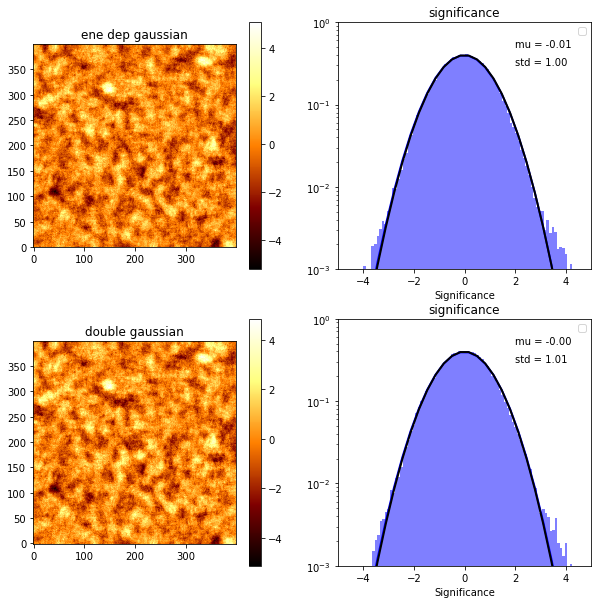

In [42]:
estimator = ExcessMapEstimator(correlation_radius=0.1*u.deg,
                               selection_optional=None)
residual5 = estimator.run(dataset1)
residual6 = estimator.run(dataset2)

plt.figure(figsize=(10,10))

ax1 = plt.subplot(221)
residual5['sqrt_ts'].plot(ax=ax1, add_cbar=True);
ax1.set_title('ene dep gaussian')

ax2 = plt.subplot(222)
plot_hist(residual5['sqrt_ts'], ax2);
ax2.set_title('significance')

ax3 = plt.subplot(223)
residual6['sqrt_ts'].plot(ax=ax3, add_cbar=True);
ax3.set_title('double gaussian')

ax4 = plt.subplot(224)
plot_hist(residual6['sqrt_ts'], ax4);
ax4.set_title('significance')



It is almost impossible to distinguish between the two cases by looking at the residuals

### Using AIC

$L_{AIC} = expˆ({-(AIC_1 - AIC_{min})/2.0})$ as in https://arxiv.org/pdf/1801.06020.pdf

In [43]:
L_AIC = np.exp((-AIC_4 + AIC_1)/2.0)
print(AIC_4 - AIC_1, L_AIC)

124.36815902369563 9.858195029666279e-28


The AIC is a strong discriminant. Otherwise, if we just look at the del L

In [44]:
from scipy.stats import chi2
print('Significance of energy dep gaussian: ', (L0-L1), 'p-value:' ,(chi2.sf(L0-L1,4)))

Significance of energy dep gaussian:  1326.4878443906782 p-value: 6.013842141273818e-286


In [45]:
print('Significance of first gaussian: ', (L0-L3), 'p-value:' ,(chi2.sf(L0-L3,4)))
print('Significance of second gaussian: ', (L3-L4), 'p-value:' ,(chi2.sf(L3-L4,4)))

Significance of first gaussian:  1144.344629033003 p-value: 1.8492954985245033e-246
Significance of second gaussian:  65.77505633397959 p-value: 1.7667206498612758e-13


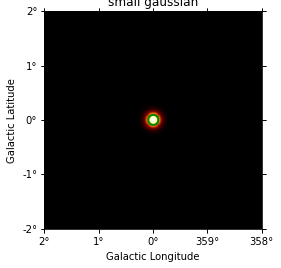

In [77]:
spatial_model2a.plot(geom=geom.to_image());
spatial_model2a.to_region().to_pixel(wcs=geom.wcs).plot(edgecolor='green', 
                                                        facecolor='none', alpha=1.0, lw=2)
plt.title('small gaussian');

Text(0.5, 1.0, 'large gaussian')

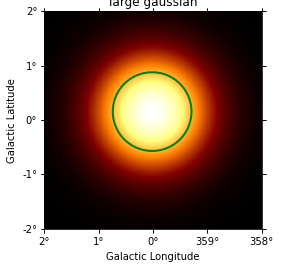

In [78]:
spatial_model2b.plot(geom=geom.to_image());
spatial_model2b.to_region().to_pixel(wcs=geom.wcs).plot(edgecolor='green', 
                                                        facecolor='none', 
                                                        alpha=1.0, lw=2);
plt.title('large gaussian')

/Users/asinha/Gammapy-dev/gammapy/gammapy/modeling/models/spectral.py:405: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/Users/asinha/Gammapy-dev/gammapy/gammapy/modeling/models/spectral.py:406: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")


Text(0.5, 1.0, 'hard spectrum')

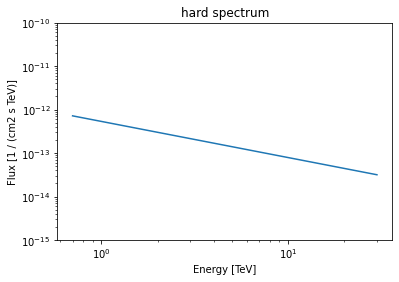

In [70]:
spectral_model2a.plot(energy_range=[0.7, 30.0]*u.TeV);
plt.ylim(1e-15,1e-10)
plt.title('hard spectrum')

/Users/asinha/Gammapy-dev/gammapy/gammapy/modeling/models/spectral.py:405: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/Users/asinha/Gammapy-dev/gammapy/gammapy/modeling/models/spectral.py:406: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")


Text(0.5, 1.0, 'soft spectrum')

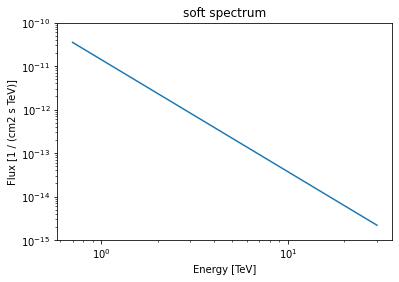

In [69]:
spectral_model2b.plot(energy_range=[0.7, 30.0]*u.TeV);
plt.ylim(1e-15,1e-10)
plt.title('soft spectrum')